# correlation bwtween hpv genes and human genes

In [1]:
library(Seurat)
library(stringr)
suppressMessages(library(ReactomePA))
suppressMessages(library(clusterProfiler))
suppressMessages(library(org.Hs.eg.db))
library(ggsci)
library(ggplot2)
library(scales)
library(dplyr)
library(harmony)
library(ComplexHeatmap)
library(dbscan)
require(pscl) 
library(Ridit)
library(purrr)
library(R.utils)
library(dbscan)
library(FNN)
library(qlcMatrix)
library(waRRior)
R.utils::setOption("clusterProfiler.download.method","auto")

Attaching SeuratObject


载入程辑包：‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


载入需要的程辑包：Rcpp

载入需要的程辑包：grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either on

In [2]:
epi = readRDS('~/HPV/res/seurat_rds/epi.rds') 
epi = epi[,!(epi$seurat_clusters %in% c('4','5','8','7','9'))]
epi = epi[,epi$nFeature_RNA <= 8000 & epi$nCount_RNA <= 50000]

In [3]:
dim(epi)

[1] 28668 10303

In [4]:
hpv = readRDS('~/HPV/res/seurat_rds/hpv_exprs.rds')
hpv = hpv[,colnames(hpv) %in% colnames(epi)]
hpv@reductions = epi@reductions
hpv@meta.data = epi@meta.data

In [5]:
which(is.na(GetAssayData(hpv)))
which(is.na(GetAssayData(epi)))
dim(epi)
dim(hpv)

integer(0)

integer(0)

[1] 28668 10303

[1]     7 10303

In [6]:
# imputation
imputation <- function(obj){
    pca_embeddings <- Embeddings(obj, "pca")
    knn_result <- get.knn(pca_embeddings, k = 5)
    expr_mat <- as.matrix(GetAssayData(obj))
    expr_raw <- as.matrix(GetAssayData(obj))
    colnames(expr_mat) = colnames(obj)
    rownames(expr_mat) = rownames(obj)
    for (i in 1:ncol(obj)){
        neighbor_index = knn_result$nn.index[i,]
        expr_mat[,i] = expr_raw[,c(i,neighbor_index)] %*% rep(1/6,6)
    }
    return(expr_mat)
}

In [7]:
host_impu = imputation(epi)
hpv_impu = imputation(hpv)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”


In [8]:
correlation = cor(t(host_impu),t(hpv_impu),method = 'spearman')
rownames(correlation) = rownames(epi)
colnames(correlation) = rownames(hpv)
correlation[is.na(correlation)] = 0
correlation = correlation[rowSums(correlation)!=0,]
saveRDS(host_impu, file = '~/HPV/res/epi/hpv_expr_cor/host_impu.rds')
saveRDS(hpv_impu, file = '~/HPV/res/epi/hpv_expr_cor/hpv_impu.rds')
saveRDS(correlation,file = '~/HPV/res/epi/hpv_expr_cor/correlation.rds')

Warning message in cor(t(host_impu), t(hpv_impu), method = "spearman"):
“标准差为零”


# positive cor and negtive cor genes

In [1]:
library(Seurat)
library(stringr)
suppressMessages(library(ReactomePA))
suppressMessages(library(clusterProfiler))
suppressMessages(library(org.Hs.eg.db))
library(ggsci)
library(ggplot2)
library(scales)
library(dplyr)
library(ComplexHeatmap)

Attaching SeuratObject


载入程辑包：‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


载入需要的程辑包：grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Com

In [2]:
host_impu = readRDS('~/HPV/res/epi/hpv_expr_cor/host_impu.rds')
hpv_impu = readRDS('~/HPV/res/epi/hpv_expr_cor/hpv_impu.rds')
correlation = readRDS('~/HPV/res/epi/hpv_expr_cor/correlation.rds')

In [21]:
#select genes to plot in the heatmap
genes = list()
for (i in 1:7){
    genes[[i]] = rownames(correlation)[order(correlation[,i],decreasing = TRUE)][1:500]
    genes[[i]] = c(genes[[i]],rownames(correlation)[order(correlation[,i],decreasing = FALSE)][1:500])
}
genes = genes %>% purrr::reduce(union)
length(genes)

[1] 3032

In [24]:
'CDKN2A' %in% genes

[1] FALSE

In [ ]:
#top 10 correlated genes
mark_genes = c(genes[order(rowSums(correlation[genes,]),decreasing = TRUE)[1:10]],genes[order(rowSums(correlation[genes,]))[1:10]])
genes[order(rowSums(correlation[genes,]),decreasing = TRUE)[1:10]]
genes[order(rowSums(correlation[genes,]))[1:10]]

[1] "SYCP2"      "AC011997.1" "AC005993.1" "DLEU1"      "GINS1"     
 [6] "SLC25A43"   "LINC00884"  "NSMCE2"     "ZNF337-AS1" "ITGB6"

[1] "FBXO32"   "MAP1LC3B" "GADD45B"  "TCF4"     "MAFF"     "YPEL5"   
 [7] "PPP1R15A" "PELI1"    "HECA"     "KLF4"

In [5]:
options(repr.plot.width = 4, repr.plot.height = 4)
ha = rowAnnotation(foo = anno_mark(at = which(genes %in% mark_genes), 
    labels = genes[which(genes %in% mark_genes)]))
ht1 = Heatmap(correlation[genes,], show_row_names = FALSE, row_split = 3, row_title = NULL, right_annotation = ha, heatmap_legend_param = list(title = gt_render("Correlation")))

载入需要的名字空间：gridtext



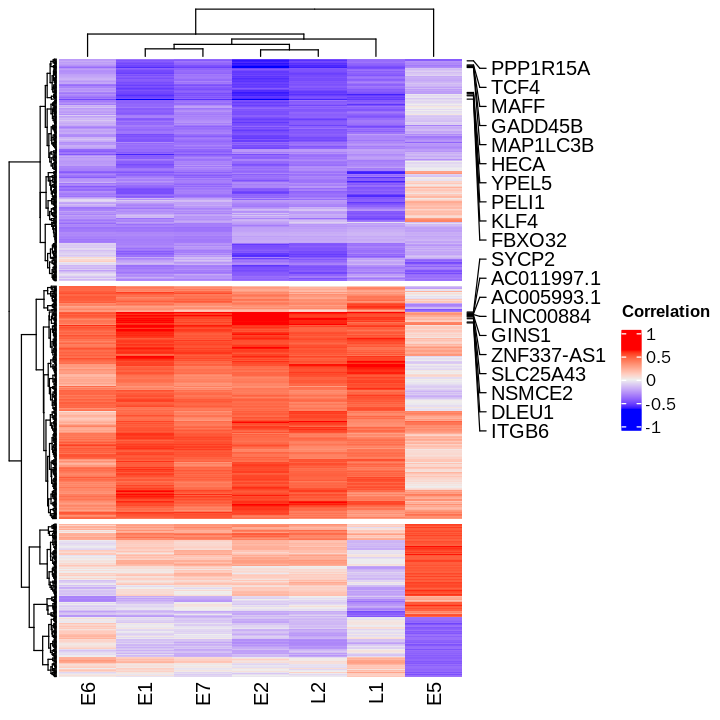

In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)
ht = draw(ht1)

In [7]:
pos_genes = genes[row_order(ht)[[2]]]
neg_genes = genes[row_order(ht)[[1]]]

In [10]:
#go analysis
gos = list()
go <- enrichGO(pos_genes,ont = "BP",OrgDb = 'org.Hs.eg.db',keyType = 'SYMBOL')
gos[['pos']] = go
pdf(paste0('~/HPV/res/epi/hpv_expr_cor/enrichment/go/pos.pdf'),width = 7,height = 3.5)
print(dotplot(go,label_format = 60))
dev.off()
go <- enrichGO(neg_genes,ont = "BP",OrgDb = 'org.Hs.eg.db',keyType = 'SYMBOL')
gos[['neg']] = go
pdf(paste0('~/HPV/res/epi/hpv_expr_cor/enrichment/go/neg.pdf'),width = 7 ,height = 3.8)
print(dotplot(go,label_format = 60))
dev.off()
saveRDS(gos, file = '~/HPV/res/epi/hpv_expr_cor/enrichment/go/gos.rds')

png 
  2

png 
  2

In [11]:
gos[['neg']]@result[1:10,]

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0048545,GO:0048545,response to steroid hormone,20/237,339/18903,1.122487e-08,3.769313e-05,3.120515e-05,FOSB/FOXO3/HSPA1A/ERRFI1/HSPA1B/FBXO32/SGK1/ZFP36L2/CRY1/PER1/ISL1/AR/ANXA1/BCL2/AREG/ZFP36/TMF1/PGR/GHR/FOS,20
GO:0071383,GO:0071383,cellular response to steroid hormone stimulus,15/237,209/18903,6.423694e-08,9.019564e-05,7.467060e-05,FOXO3/HSPA1A/ERRFI1/HSPA1B/FBXO32/SGK1/ZFP36L2/CRY1/PER1/ISL1/AR/ANXA1/ZFP36/TMF1/PGR,15
GO:2001236,GO:2001236,regulation of extrinsic apoptotic signaling pathway,13/237,155/18903,8.057978e-08,9.019564e-05,7.467060e-05,ATF3/HSPA1A/DEDD2/HSPA1B/GCLC/MCL1/AR/LGALS3/HMOX1/TMBIM1/BCL2/PMAIP1/RIPK1,13
GO:0097191,GO:0097191,extrinsic apoptotic signaling pathway,15/237,224/18903,1.593808e-07,1.128007e-04,9.338471e-05,ATF3/FOXO3/HSPA1A/DEDD2/HSPA1B/GCLC/MCL1/AR/GABARAP/LGALS3/HMOX1/TMBIM1/BCL2/PMAIP1/RIPK1,15
GO:0031960,GO:0031960,response to corticosteroid,13/237,165/18903,1.679581e-07,1.128007e-04,9.338471e-05,FOSB/FOXO3/ERRFI1/FBXO32/SGK1/ZFP36L2/ISL1/ANXA1/BCL2/AREG/ZFP36/GHR/FOS,13
GO:0051384,GO:0051384,response to glucocorticoid,12/237,142/18903,2.363168e-07,1.272474e-04,1.053448e-04,FOSB/FOXO3/ERRFI1/FBXO32/ZFP36L2/ISL1/ANXA1/BCL2/AREG/ZFP36/GHR/FOS,12
GO:0030522,GO:0030522,intracellular receptor signaling pathway,16/237,266/18903,2.652566e-07,1.272474e-04,1.053448e-04,HSPA1A/NFKBIA/CITED2/HSPA1B/CRY1/PER1/ISL1/RIOK3/AR/TMF1/NR1D2/THRB/RORA/PGR/NR4A1/KLF2,16
GO:2001237,GO:2001237,negative regulation of extrinsic apoptotic signaling pathway,10/237,99/18903,4.661981e-07,1.956867e-04,1.620039e-04,HSPA1A/HSPA1B/GCLC/MCL1/AR/LGALS3/HMOX1/TMBIM1/BCL2/RIPK1,10
GO:0071384,GO:0071384,cellular response to corticosteroid stimulus,8/237,64/18903,1.311620e-06,4.893801e-04,4.051449e-04,FOXO3/ERRFI1/FBXO32/SGK1/ZFP36L2/ISL1/ANXA1/ZFP36,8


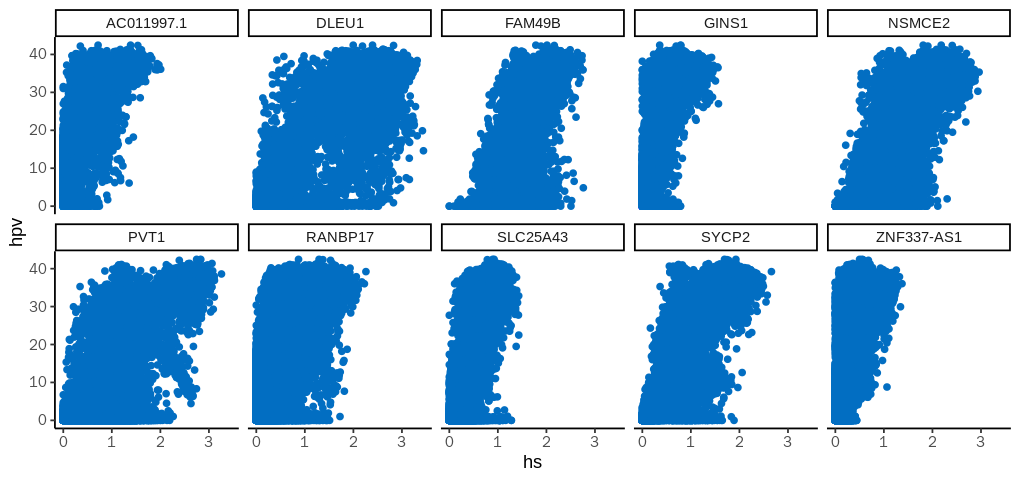

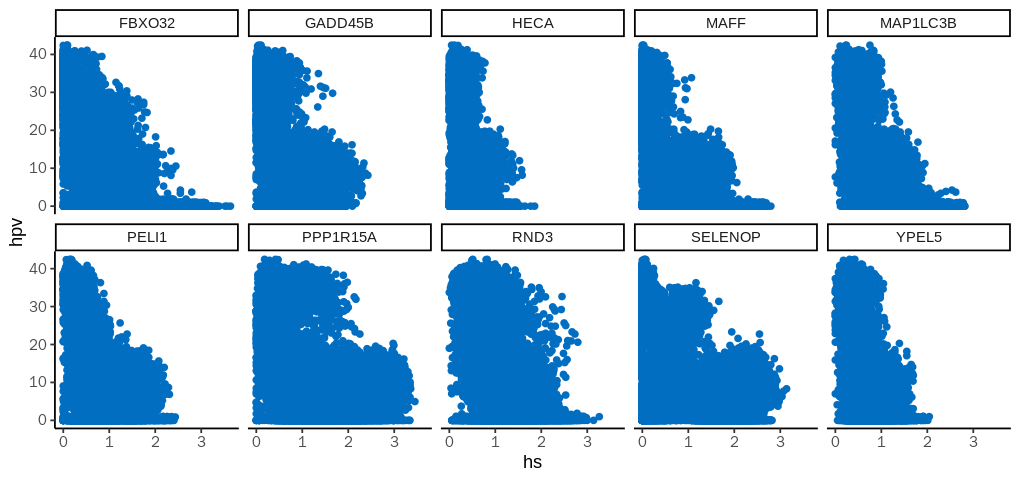

In [12]:
options(repr.plot.width = 8.5, repr.plot.height = 4)
coexprs = list()
for (gene in genes[order(rowSums(correlation[genes,]),decreasing = TRUE)[1:10]]){
   coexprs[[gene]] = data.frame(hs = host_impu[gene,], hpv = colSums(hpv_impu), gene = gene) 
}
coexprs = coexprs %>% purrr::reduce(rbind)
ggplot(coexprs) + geom_point(aes(x = hs, y = hpv),color = '#026EC2')+ facet_wrap(.~gene,nrow = 2) + theme_classic()
coexprs = list()
for (gene in genes[order(rowSums(correlation[genes,]))[1:10]]){
   coexprs[[gene]] = data.frame(hs = host_impu[gene,], hpv = colSums(hpv_impu), gene = gene) 
}
coexprs = coexprs %>% purrr::reduce(rbind)
ggplot(coexprs) + geom_point(aes(x = hs, y = hpv),color = '#026EC2')+ facet_wrap(.~gene,nrow = 2) + theme_classic()

# compare E5 E6 and E7

In [1]:
library(Seurat)
library(stringr)
library(ggplot2)
library(dplyr)
library(ComplexHeatmap)
library(purrr)
library(stringr)
suppressMessages(library(ReactomePA))
suppressMessages(library(clusterProfiler))
suppressMessages(library(org.Hs.eg.db))
library(enrichplot)
library(corrplot)
library(RColorBrewer)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


corrplot 0.92 loaded



In [2]:
correlation = readRDS('~/HPV/res/epi/hpv_expr_cor/correlation.rds')

In [3]:
dim(correlation)

[1] 27695     7

In [4]:
hpv_cor = cor(correlation,correlation)
saveRDS(hpv_cor, file = '~/HPV/res/epi/hpv_expr_cor/e567/hpv_cor.rds')

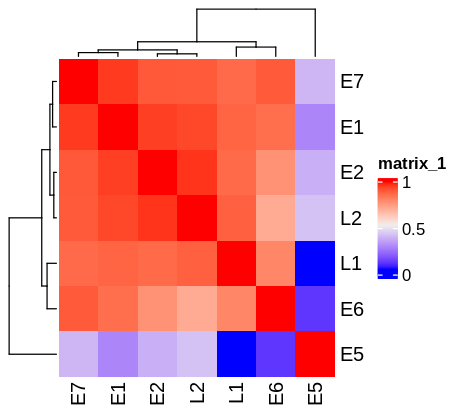

In [5]:
options(repr.plot.width = 3.8, repr.plot.height = 3.5)
Heatmap(hpv_cor)

In [148]:
gseas = list()
#gsea analysis
for (gene in c('E5','E6','E7')){
    if (gene == 'E5'){
        n = 10000
    } else if (gene == 'E6'){
        n = 10000
    } else if (gene == 'E7'){
        n = 15000
    }
    genes = rownames(correlation)[order(abs(correlation[,gene]),decreasing = TRUE)][1:n]
    cor = correlation[,gene][order(abs(correlation[,gene]),decreasing = TRUE)][1:n]
    names(cor) = genes
    genes = names(cor)[order(cor,decreasing = TRUE)]
    cor = cor[order(cor,decreasing = TRUE)]
    names(cor) = genes
    message(length(cor))
    geneset = read.gmt('~/HPV/ref/pathways/h.all.v2023.1.Hs.symbols.gmt')
    gsea = GSEA(geneList = cor,TERM2GENE = geneset,nPermSimple = 10000)
    path = paste0('~/HPV/res/epi/hpv_expr_cor/e567/enrichment/hallmark/',gene,'/')
    if (!dir.exists(path)){
        dir.create(path)
    }
    saveRDS(gsea, file = paste0(path,'gsea.rds'))
    gseas[[gene]] = gsea@result %>% arrange(desc(abs(enrichmentScore)))
    write.table(gseas[[gene]],file = paste0(path,'gsea.txt'),col.names = TRUE,row.names = FALSE, quote = FALSE, sep = '\t')
    id = gsea@result$ID
    for (i in id){
        pdf(file = paste0(path,i,'.pdf'), width = 6,height = 5)
        print(gseaplot2(gsea, geneSetID = i, pvalue_table = FALSE))
        dev.off()
    }
}

10000

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...

10000

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...

15000

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [149]:
pathways = list()
for (i in 1:length(gseas)){
    pathways[[i]] = gseas[[i]]$ID
}
pathways = pathways %>% purrr::reduce(intersect)

In [150]:
pathways

[1] "HALLMARK_TNFA_SIGNALING_VIA_NFKB"          
 [2] "HALLMARK_MYC_TARGETS_V1"                   
 [3] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"          
 [4] "HALLMARK_E2F_TARGETS"                      
 [5] "HALLMARK_INTERFERON_GAMMA_RESPONSE"        
 [6] "HALLMARK_INTERFERON_ALPHA_RESPONSE"        
 [7] "HALLMARK_INFLAMMATORY_RESPONSE"            
 [8] "HALLMARK_DNA_REPAIR"                       
 [9] "HALLMARK_G2M_CHECKPOINT"                   
[10] "HALLMARK_APOPTOSIS"                        
[11] "HALLMARK_ESTROGEN_RESPONSE_EARLY"          
[12] "HALLMARK_MYOGENESIS"                       
[13] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
[14] "HALLMARK_IL2_STAT5_SIGNALING"              
[15] "HALLMARK_P53_PATHWAY"                      
[16] "HALLMARK_HYPOXIA"

In [151]:
nes_matrix = as.data.frame(matrix(0, ncol = 3, nrow = length(pathways)))

In [152]:
for (i in 1:length(gseas)){
    for (j in 1:length(pathways)){
        if (pathways[j] %in% gseas[[i]]$ID){
            nes_matrix[j,i] = gseas[[i]][pathways[j],'NES']
        }
    }
}

In [153]:
colnames(nes_matrix) = names(gseas)
rownames(nes_matrix) = pathways
saveRDS(nes_matrix,file = '~/HPV/res/epi/hpv_expr_cor/e567/enrichment//hallmark/nes_matrix.rds')

In [154]:
rownames(nes_matrix) = gsub('HALLMARK_','',rownames(nes_matrix))

In [134]:
options(repr.plot.width = 6,repr.plot.height = 3.5)
Heatmap(nes_matrix,cluster_rows = TRUE)

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


In [135]:
gsea = read.table('~/HPV/res/epi/hpv_expr_cor/e567/enrichment/hallmark/E5/gsea.txt',header = TRUE,sep = '\t')

In [136]:
gsea = gsea %>% arrange(desc(abs(NES)))

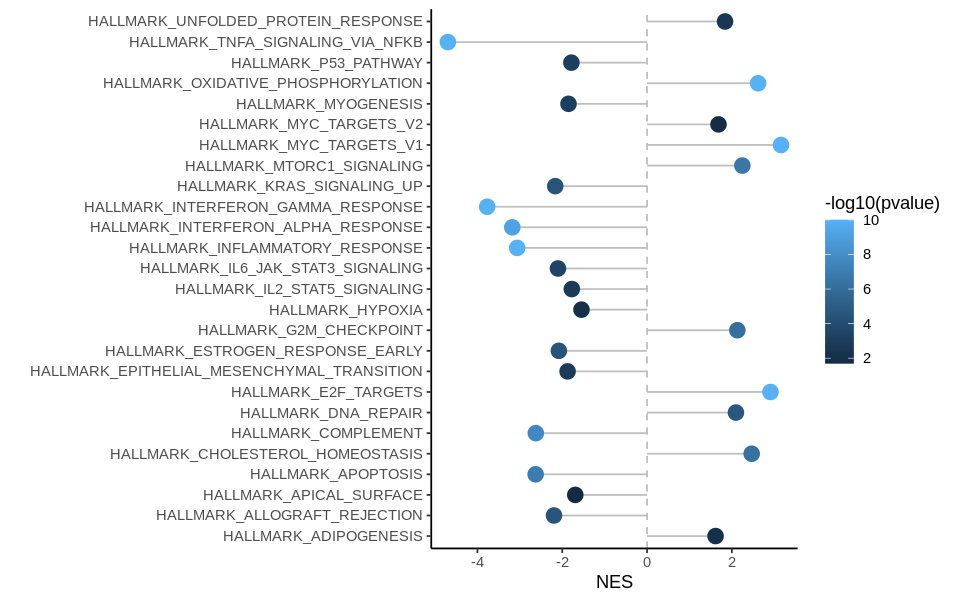

In [137]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(gsea, aes(x=ID,y=NES)) +
  geom_segment( aes(x=ID, xend=ID, y=0, yend=NES), color="grey") +
  geom_point(aes(color = -log10(pvalue)), size=4) +
  theme_classic() +
  geom_hline(yintercept = 0,linetype = 2, color = 'gray') + 
  xlab("") +
  ylab("NES") + 
  coord_flip()

In [138]:
gsea = read.table('~/HPV/res/epi/hpv_expr_cor/e567/enrichment/hallmark/E6/gsea.txt',header = TRUE,sep = '\t')

In [139]:
gsea = gsea %>% arrange(desc(abs(NES)))

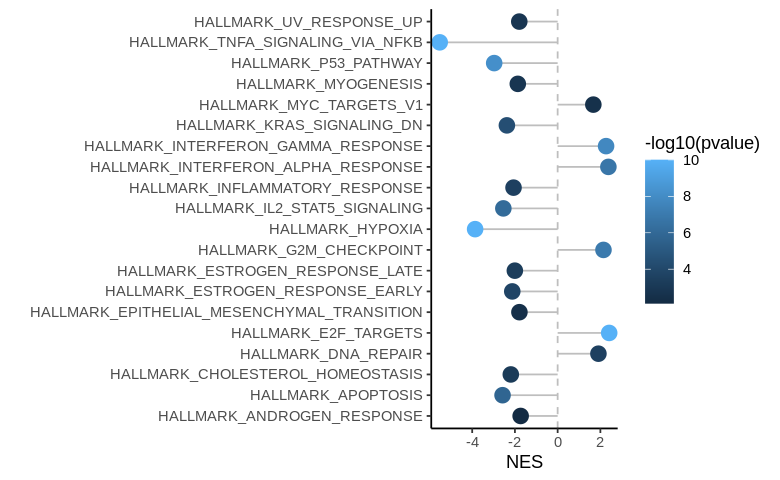

In [141]:
options(repr.plot.width = 6.5, repr.plot.height = 4)
ggplot(gsea, aes(x=ID,y=NES)) +
  geom_segment( aes(x=ID, xend=ID, y=0, yend=NES), color="grey") +
  geom_point(aes(color = -log10(pvalue)), size=4) +
  theme_classic() +
  geom_hline(yintercept = 0,linetype = 2, color = 'gray') + 
  xlab("") +
  ylab("NES") + 
  coord_flip()

In [142]:
gsea = read.table('~/HPV/res/epi/hpv_expr_cor/e567/enrichment/hallmark/E7/gsea.txt',header = TRUE,sep = '\t')

In [143]:
gsea = gsea %>% arrange(desc(abs(NES)))

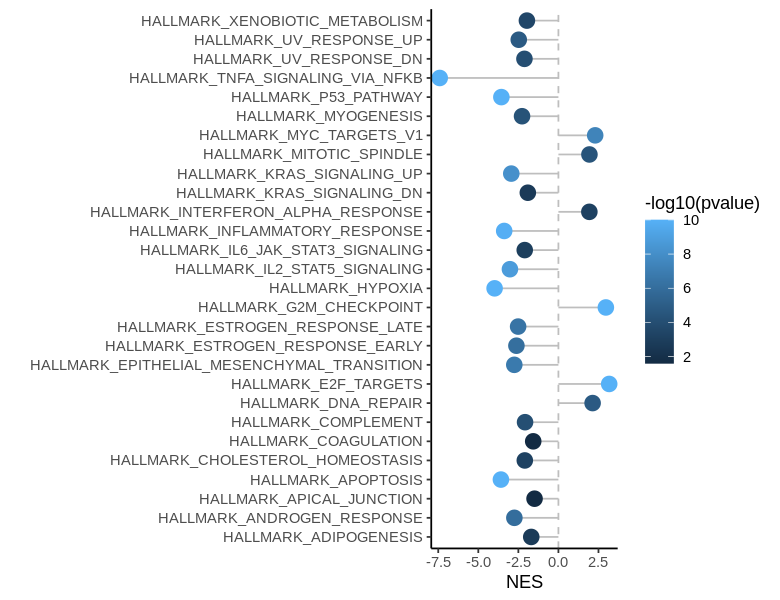

In [144]:
options(repr.plot.width = 6.5, repr.plot.height = 5)
ggplot(gsea, aes(x=ID,y=NES)) +
  geom_segment( aes(x=ID, xend=ID, y=0, yend=NES), color="grey") +
  geom_point(aes(color = -log10(pvalue)), size=4) +
  theme_classic() +
  geom_hline(yintercept = 0,linetype = 2, color = 'gray') + 
  xlab("") +
  ylab("NES") + 
  coord_flip()